In [37]:
from typing import List, Dict, Mapping, Tuple

import chex
import jax
import jax.numpy as jnp
import jax.random as jrand
import flax.linen as nn
from flax.training import train_state  # Useful dataclass to keep train state
import optax
import tensorflow as tf
import pdb
import functools

def println(*args):
  for arg in args:
    print(arg)


In [38]:
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()
# jax.devices()

In [39]:
DEVICE_COUNT = len(jax.devices())
DEVICE_COUNT

1

In [40]:
BATCH_SIZE = 96

## Dataset pipline

In [41]:
import tensorflow as tf

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert the labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

def create_dataset():
  # Create a TensorFlow data pipeline for the training set
  train_dataset = (
      tf.data.Dataset
      .from_tensor_slices((x_train, y_train))
      .repeat()
      .shuffle(buffer_size=5000)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
      .as_numpy_iterator())

  # Create a TensorFlow data pipeline for the test set.
  test_dataset = (
      tf.data.Dataset
      .from_tensor_slices((x_test, y_test))
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
      .as_numpy_iterator())
  return train_dataset, test_dataset

def get_batch(dataset):
  images, labels = next(dataset)

  images, labels = jnp.array(images), jnp.array(labels)
  images = jnp.reshape(images, (BATCH_SIZE, -1)) # flatten the images
  return images, labels

train_dataset, test_dataset = create_dataset()

### test get_batch

In [42]:
test_images, test_labels = get_batch(train_dataset)
test_images.shape, test_labels.shape

((96, 784), (96, 10))

In [43]:
test_image, est_label = test_images[0], test_labels[0]
test_image.shape

(784,)

## Modeling

In [44]:
class Autoencoder(nn.Module):

  def setup(self):
    self._encoder = nn.Sequential([
        nn.Dense(128), # 784->128
        nn.relu,
        nn.Dense(64), # 128->64
        nn.relu,
        nn.Dense(12), # 64->12
        nn.relu,
        nn.Dense(3) # 12->3
    ])

    self._decoder = nn.Sequential([
        nn.Dense(12), # 3->12
        nn.relu,
        nn.Dense(64), # 12->64
        nn.relu,
        nn.Dense(128), # 64->128
        nn.relu,
        nn.Dense(784), # 128->784
        nn.sigmoid
    ])

  def __call__(self, x):
    encoded = self._encoder(x)
    decoded = self._decoder(encoded)
    return decoded

In [45]:
model = Autoencoder()
params = model.init(jrand.PRNGKey(99), jnp.zeros(shape=(1, 784)))["params"]
opt = optax.adam(learning_rate=0.001)

In [46]:
train_dataset, test_dataset = create_dataset()
images, labels = get_batch(train_dataset)

In [47]:
recons = model.apply({"params": params}, images)

In [57]:
state = train_state.TrainState.create(apply_fn=model.apply,
                                      params=params,
                                      tx=opt)

In [54]:
def mse_loss(input, recon):
  return jnp.mean((input - recon)**2)

In [55]:
def train_step(params, state, batch):
  def _compute_loss(params):
    inputs, _ = batch
    recons = state.apply_fn({"params": params}, inputs)
    recon_losses = jax.vmap(mse_loss)(inputs, recons)
    loss = jnp.mean(recon_losses) # mean loss across batch
    return loss

  grad_fn = jax.value_and_grad(_compute_loss)
  loss, grads = grad_fn(params)
  state = state.apply_gradients(grads=grads)
  return state, loss

In [56]:
state, loss = train_step(params, state, (images, labels))

In [58]:
# Training loop
num_epochs = 10
steps_per_epoch = len(x_train) // BATCH_SIZE
train_step_jit = jax.jit(train_step)

for epoch in range(num_epochs):
    print("epoch: ", epoch)
    train_dataset, _ = create_dataset()

    for step in range(steps_per_epoch):
        batch = get_batch(train_dataset)

        params = state.params
        state, loss = train_step_jit(params, state, batch)
        print("loss", loss) if step%100==0 else None


epoch:  0
loss 0.03814809
loss 0.036361426
loss 0.035029557
loss 0.03749001
loss 0.035308518
loss 0.033923037
loss 0.034810554
epoch:  1
loss 0.03338395
loss 0.037977047
loss 0.038017806
loss 0.036508657
loss 0.03556865
loss 0.03623856
loss 0.033175398
epoch:  2
loss 0.03373265
loss 0.034444228
loss 0.031594124
loss 0.03535674
loss 0.03385376
loss 0.036111355
loss 0.035825126
epoch:  3
loss 0.03400152
loss 0.03270468
loss 0.03390874
loss 0.035919745
loss 0.03248319
loss 0.035045996
loss 0.035396002
epoch:  4
loss 0.03161389
loss 0.032522596
loss 0.035424363
loss 0.032336816
loss 0.034515068
loss 0.03133424
loss 0.031015143
epoch:  5
loss 0.031191632
loss 0.035947736
loss 0.032927502
loss 0.037334703
loss 0.03427604
loss 0.033957526
loss 0.03395548
epoch:  6
loss 0.032698106
loss 0.03343622
loss 0.033752866
loss 0.035672054
loss 0.032802805
loss 0.035579856
loss 0.031805504
epoch:  7
loss 0.03145571
loss 0.032168686
loss 0.031766262
loss 0.03524249
loss 0.032872595
loss 0.031562053
loss

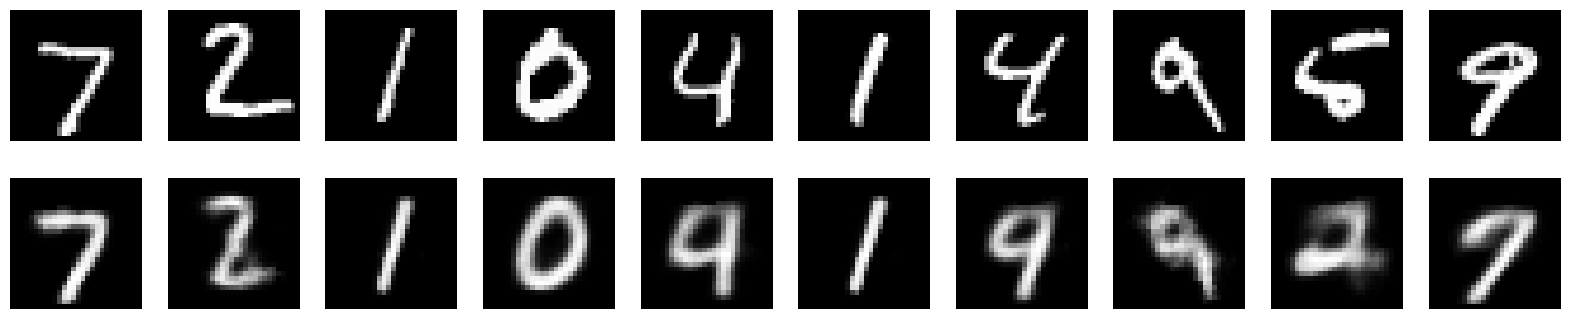

In [59]:
import matplotlib.pyplot as plt

def plot_reconstructions(model, params, batch, n=10):
    inputs, _ = batch
    reconstructed = state.apply_fn({"params": state.params}, inputs)
    fig, axes = plt.subplots(2, n, figsize=(n * 2, 4))
    for i in range(n):
        axes[0, i].imshow(inputs[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
    plt.show()

# Visualize some reconstructions
train_dataset, test_dataset = create_dataset()
plot_reconstructions(model, params, get_batch(test_dataset))
